In [1]:
from PIL import Image
from numpy import *
from pylab import *
import numpy as np

In [2]:
import camera
import homography
import sfm
import sift
camera = reload(camera)
homography = reload(homography)
sfm = reload(sfm)
sift = reload(sift)

In [3]:
# Read features
im1 = array(Image.open('images2/001.jpg'))
sift.process_image('images2/001.jpg', 'im1.sift')

im2 = array(Image.open('images2/002.jpg'))
sift.process_image('images2/002.jpg', 'im2.sift')


processed tmp.pgm to im1.sift
processed tmp.pgm to im2.sift


In [4]:
l1, d1 = sift.read_features_from_file('im1.sift')
l2, d2 = sift.read_features_from_file('im2.sift')

In [5]:
matches = sift.match_twosided(d1, d2)

In [6]:
ndx = matches.nonzero()[0]
x1 = homography.make_homog(l1[ndx, :2].T)
ndx2 = [int(matches[i]) for i in ndx]
x2 = homography.make_homog(l2[ndx2, :2].T)

d1n = d1[ndx]
d2n = d2[ndx2]
x1n = x1.copy()
x2n = x2.copy()

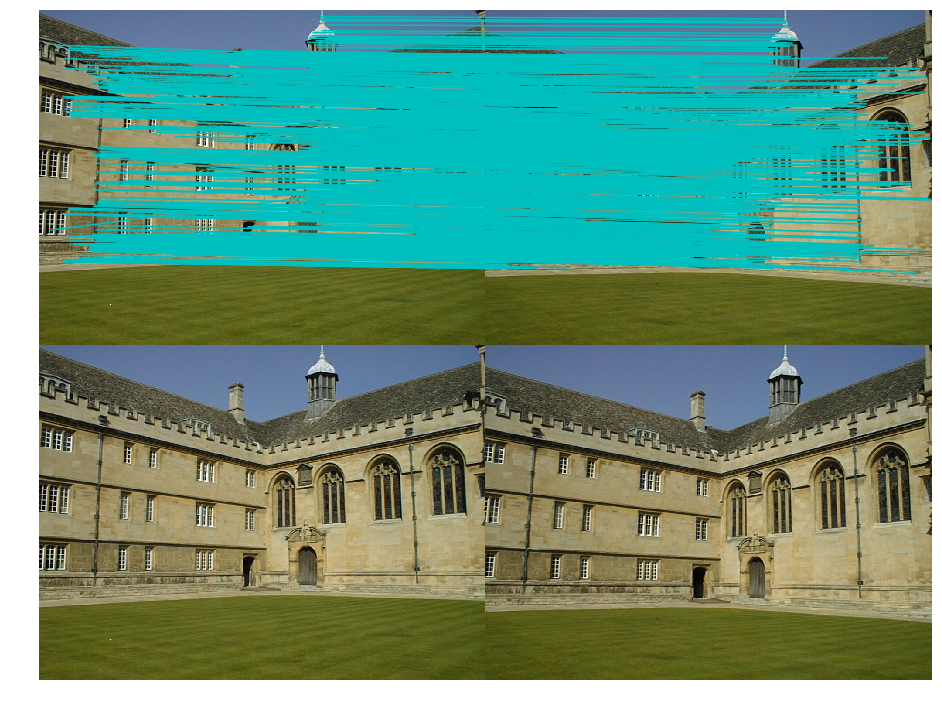

In [7]:
figure(figsize=(16,16))
sift.plot_matches(im1, im2, l1, l2, matches, True)
show()

In [26]:
#def F_from_ransac(x1, x2, model, maxiter=5000, match_threshold=1e-6):
def F_from_ransac(x1, x2, model, maxiter=5000, match_threshold=1e-6):
    """ Robust estimation of a fundamental matrix F from point
    correspondences using RANSAC (ransac.py from
    http://www.scipy.org/Cookbook/RANSAC).

    input: x1, x2 (3*n arrays) points in hom. coordinates. """

    import ransac
    data = np.vstack((x1, x2))
    d = 10 # 20 is the original
    # compute F and return with inlier index
    F, ransac_data = ransac.ransac(data.T, model,
                                   8, maxiter, match_threshold, d, return_all=True)
    return F, ransac_data['inliers']

In [27]:
# find F through RANSAC
model = sfm.RansacModel()
F, inliers = F_from_ransac(x1n, x2n, model, maxiter=5000, match_threshold=1e-5)
print F

[[ -1.20596150e-07   4.57524773e-06  -2.72747465e-03]
 [ -1.25371232e-06   4.07586096e-07   2.16551968e-02]
 [  1.33001700e-03  -2.30377515e-02   1.00000000e+00]]


In [28]:
P1 = array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])
P2 = sfm.compute_P_from_fundamental(F)

In [29]:
print P2
print F

[[ -1.58601475e+00   1.25923669e+01   5.81517049e+02   4.98349903e+03]
 [  1.35923671e+01  -1.07918654e+02  -4.98349770e+03   5.81494011e+02]
 [  2.28708685e-02   2.76023112e-03  -1.15582009e+02   1.00000000e+00]]
[[ -1.20596150e-07   4.57524773e-06  -2.72747465e-03]
 [ -1.25371232e-06   4.07586096e-07   2.16551968e-02]
 [  1.33001700e-03  -2.30377515e-02   1.00000000e+00]]


In [30]:
# P2, F (1e-4, d=20)
# [[ -1.48067422e+00   1.14802177e+01   5.62878044e+02   4.74418238e+03]
#  [  1.24802182e+01  -9.67640761e+01  -4.74418113e+03   5.62856097e+02]
#  [  2.16588305e-02   3.69220292e-03  -1.04831621e+02   1.00000000e+00]]
# [[ -1.14890281e-07   4.55171451e-06  -2.63063628e-03]
#  [ -1.26569570e-06   6.28095242e-07   2.03963649e-02]
#  [  1.25746499e-03  -2.19476910e-02   1.00000000e+00]]

In [31]:
# triangulate inliers and remove points not in front of both cameras
X = sfm.triangulate(x1n[:, inliers], x2n[:, inliers], P1, P2)

In [32]:
# plot the projection of X
cam1 = camera.Camera(P1)
cam2 = camera.Camera(P2)
x1p = cam1.project(X)
x2p = cam2.project(X)

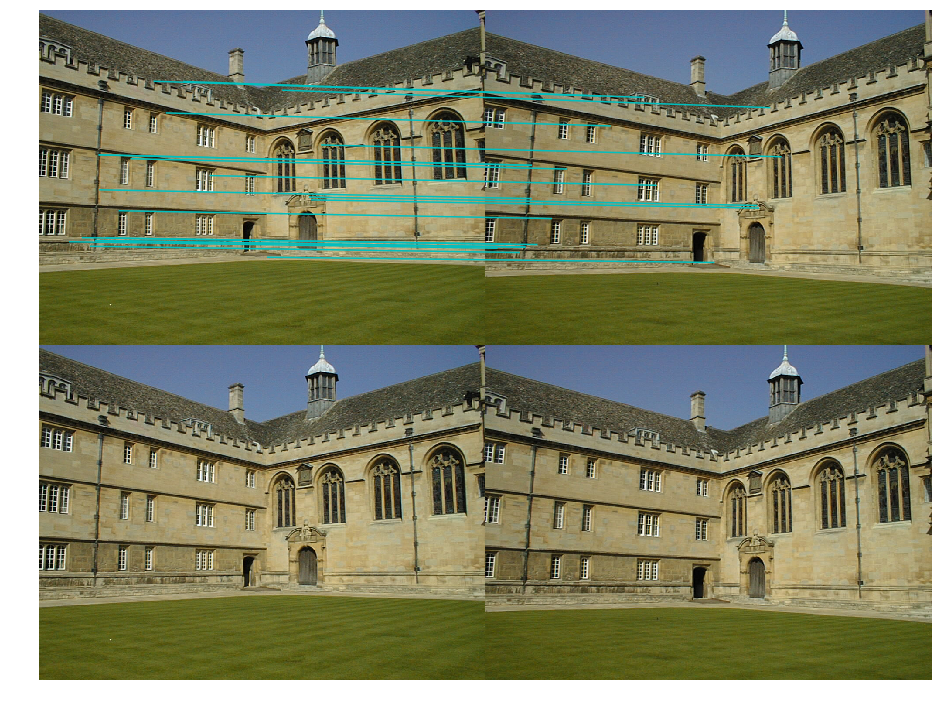

In [33]:
figure(figsize=(16, 16))
imj = sift.appendimages(im1, im2)
imj = vstack((imj, imj))

imshow(imj)

cols1 = im1.shape[1]
rows1 = im1.shape[0]
for i in range(len(x1p[0])):
    if (0<= x1p[0][i]<cols1) and (0<= x2p[0][i]<cols1) and (0<=x1p[1][i]<rows1) and (0<=x2p[1][i]<rows1):
        plot([x1p[0][i], x2p[0][i]+cols1],[x1p[1][i], x2p[1][i]],'c')
axis('off')
show()

In [34]:
d1p = d1n[inliers]
d2p = d2n[inliers]

In [35]:
# Read features
im3 = array(Image.open('images2/003.jpg'))
sift.process_image('images2/003.jpg', 'im3.sift')
l3, d3 = sift.read_features_from_file('im3.sift')

processed tmp.pgm to im3.sift


In [36]:
matches13 = sift.match_twosided(d1p, d3)

In [37]:
ndx_13 = matches13.nonzero()[0]
x1_13 = homography.make_homog(x1p[:, ndx_13])
ndx2_13 = [int(matches13[i]) for i in ndx_13]
x3_13 = homography.make_homog(l3[ndx2_13, :2].T)

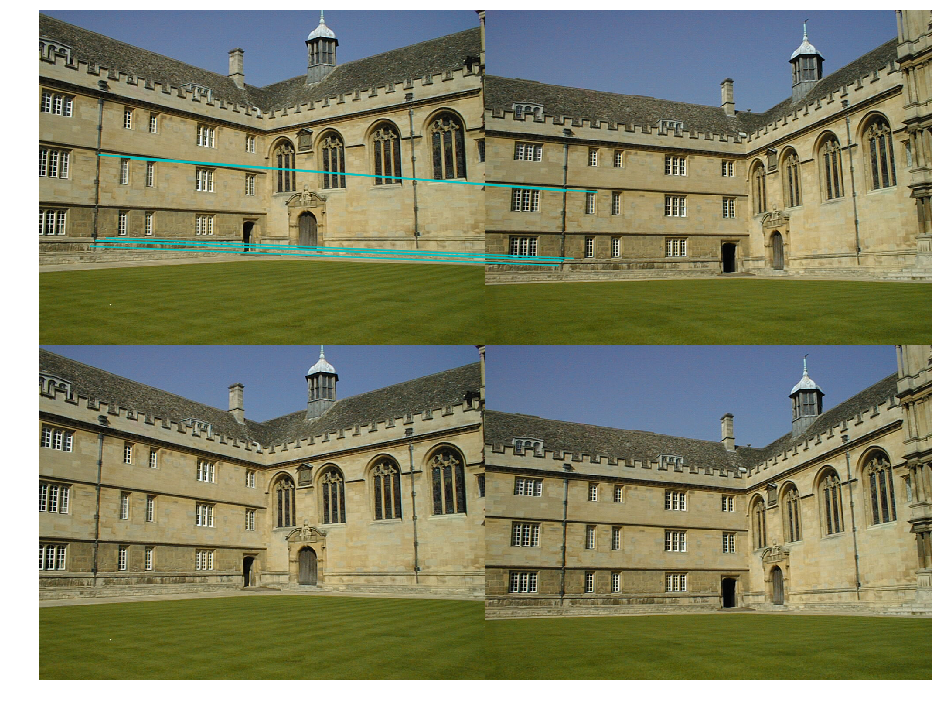

In [38]:
figure(figsize=(16, 16))
imj = sift.appendimages(im1, im3)
imj = vstack((imj, imj))

imshow(imj)

cols1 = im1.shape[1]
rows1 = im1.shape[0]
for i in range(len(x1_13[0])):
    if (0<= x1_13[0][i]<cols1) and (0<= x3_13[0][i]<cols1) and (0<=x1_13[1][i]<rows1) and (0<=x3_13[1][i]<rows1):
        plot([x1_13[0][i], x3_13[0][i]+cols1],[x1_13[1][i], x3_13[1][i]],'c')
axis('off')
show()

In [39]:
P3 = sfm.compute_P(x3_13, X[:, ndx_13])

In [40]:
print P3

[[  3.62014810e-03   1.12572805e-04   2.03235270e-02   9.73656910e-02]
 [  2.27712894e-02   2.46572006e-03  -3.98419976e-01   9.11497397e-01]
 [  3.74477593e-05   2.32922416e-06   3.21441236e-04   1.49855279e-03]]


In [41]:
print P1
print P2
print P3

[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]]
[[ -1.58601475e+00   1.25923669e+01   5.81517049e+02   4.98349903e+03]
 [  1.35923671e+01  -1.07918654e+02  -4.98349770e+03   5.81494011e+02]
 [  2.28708685e-02   2.76023112e-03  -1.15582009e+02   1.00000000e+00]]
[[  3.62014810e-03   1.12572805e-04   2.03235270e-02   9.73656910e-02]
 [  2.27712894e-02   2.46572006e-03  -3.98419976e-01   9.11497397e-01]
 [  3.74477593e-05   2.32922416e-06   3.21441236e-04   1.49855279e-03]]


In [22]:
# Can't tell the camera position because there's no calibration matrix (K)